In [22]:
import os
# Limit OpenMP to a single thread to prevent multithreading conflicts
os.environ["OMP_NUM_THREADS"] = '1'

import numpy as np  # NumPy for numerical computations
import pandas as pd  # pandas for handling and analyzing data
import seaborn as sns  # seaborn for enhanced data visualization
import matplotlib.pyplot as plt  # matplotlib for creating plots
import matplotlib.ticker as ticker  # ticker for customizing plot axis ticks
import scipy.optimize as opt  # scipy.optimize for fitting functions to data
import errors as err  # Custom module for error propagation (user-defined)
from sklearn.preprocessing import MinMaxScaler  # Scales features to a specified range
import cluster_tools as ct  # Custom module for clustering tools (user-defined)
from sklearn.cluster import KMeans  # KMeans algorithm for clustering data
from sklearn.metrics import silhouette_score  # Evaluates clustering quality using silhouette score

# Disable pandas warnings for chained assignments
pd.options.mode.chained_assignment = None


In [23]:
def format_number_k_m(x, pos):
    """Format numbers with 'K' for thousands or 'M' for millions."""
    if x >= 1_000_000:
        return f'{x / 1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x / 1_000:.1f}K'
    else:
        return int(x)

In [24]:
def plot_bar_with_annotations(df, x_col, y_col, title='', xlabel='', ylabel='', palette='viridis', use_multiple_colors=False):
    """
    Plots a bar chart with value annotations using seaborn and matplotlib.

    Args:
        df (pandas.DataFrame): Data source for the plot.
        x_col (str): Column name for x-axis categories.
        y_col (str): Column name for y-axis values.
        title (str, optional): Plot title.
        xlabel (str, optional): Label for the x-axis.
        ylabel (str, optional): Label for the y-axis.
        palette (str, optional): Color palette for bars.
        use_multiple_colors (bool, optional): Whether to assign different colors to each bar.
    """

    # Set up the plot size
    plt.figure(figsize=(10, 6))

    # Generate the barplot
    if use_multiple_colors:
        barplot = sns.barplot(x=x_col, y=y_col, data=df, hue=x_col, palette=palette, legend=False)
    else:
        barplot = sns.barplot(x=x_col, y=y_col, data=df, color=sns.color_palette(palette)[0])

    # Format y-axis tick labels to use 'K'/'M'
    barplot.yaxis.set_major_formatter(ticker.FuncFormatter(format_number_k_m))

    # Add text annotations above each bar
    for p in barplot.patches:
        barplot.annotate(format_number_k_m(p.get_height(), None),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center',
                         xytext=(0, 10), textcoords='offset points')

    # Apply labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.tight_layout()
    plt.savefig('Bar.png', dpi=300)
    plt.show()


In [25]:
def plot_correlation_matrix(df, title='Correlation Matrix', cmap='coolwarm', show_values=True, figsize=(10, 8)):
    """
    Displays a heatmap of the correlation matrix for a DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame to compute correlations from.
        title (str, optional): Title of the plot.
        cmap (str, optional): Colormap used in the heatmap.
        show_values (bool, optional): Whether to annotate cells with correlation values.
        figsize (tuple, optional): Size of the figure (width, height).
    """
    # Compute the correlation matrix
    corr = df.corr()

    # Initialize the plot
    plt.figure(figsize=figsize)
    sns.set(style='white')

    # Create heatmap without masking the upper triangle
    heatmap = sns.heatmap(
        corr, annot=show_values, fmt=".2f", cmap=cmap,
        cbar_kws={'shrink': .5}, linewidths=.5, square=True
    )

    # Adjust axis tick labels
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

    # Set plot title and display
    plt.title(title)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300)
    plt.show()


In [26]:
def plot_scatter_with_optional_regression(df, x_col, y_col, with_regression=False, title='', xlabel='', ylabel='', color='blue', marker='x', figsize=(8, 6)):
    """
    Plots a scatter plot for two variables, optionally with a regression line.

    Args:
        df (pandas.DataFrame): DataFrame containing the data.
        x_col (str): Column name for the x-axis.
        y_col (str): Column name for the y-axis.
        with_regression (bool, optional): Whether to overlay a regression line.
        title (str, optional): Title of the plot.
        xlabel (str, optional): Label for the x-axis.
        ylabel (str, optional): Label for the y-axis.
        color (str, optional): Color of the scatter points.
        marker (str, optional): Marker style for the scatter points.
        figsize (tuple, optional): Size of the figure as (width, height).
    """
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set(style='darkgrid')  # Apply a clean grid style

    # Plot with or without regression line
    if with_regression:
        sns.regplot(x=x_col, y=y_col, data=df,
                    scatter_kws={'color': color, 'marker': marker},
                    line_kws={'color': 'red'})
    else:
        plt.scatter(df[x_col], df[y_col], color=color, marker=marker)

    # Set axis labels and plot title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Save and display the plot
    plt.savefig('scatter_plot.png', dpi=300)
    plt.show()


In [27]:
def plot_silhouette_scores(data, max_clusters=10):
    """
    Computes and visualizes silhouette scores for a range of cluster counts using KMeans.

    Args:
        data (array-like or DataFrame): Input data for clustering.
        max_clusters (int, optional): Maximum number of clusters to evaluate (minimum is 2).

    Returns:
        None. Displays and saves a plot of silhouette scores.
    """

    silhouette_scores = []

    # Compute silhouette scores for each cluster count
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='s', color='red')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.savefig('silhouette_score.png', dpi=300)
    plt.show()


In [28]:
def extract_yearly_data_for_bar_chart(cols, ind, dataframes, year):
    """
    Extracts and reshapes data for a specified year from a selected DataFrame for bar chart visualization.

    This function selects a DataFrame from a list by its index, filters it by the provided columns and year,
    transposes the result to align entities as rows and the selected year as the column, and converts values to float.

    Args:
        cols (list of str): Column names to retain (must include 'Year').
        ind (int): Index of the target DataFrame in the dataframes list.
        dataframes (list of pandas.DataFrame): List of DataFrames to select from.
        year (str): The year to filter the data by.

    Returns:
        pandas.DataFrame: A transposed DataFrame with the specified year's data, ready for plotting.
    """
    df = dataframes[ind]           # Select the target DataFrame by index
    df = df[cols]                  # Retain only specified columns
    df = df[df['Year'] == year]    # Filter by the specified year
    df_t = df.T                    # Transpose the DataFrame
    df_t.columns = df['Year']     # Set the year as the new column header
    df_t = df_t.astype(float)     # Convert data to float for plotting
    return df_t


In [29]:
def extract_country_data_for_heatmap(indicators, data_frames, country):
    """
    Extracts and processes indicator data for a specific country to prepare it for heatmap visualization.

    Args:
        indicators (list of str): Names of indicators, possibly with extra info in parentheses.
        data_frames (list of pandas.DataFrame): List of DataFrames containing indicator data.
        country (str): The country to extract data for.

    Returns:
        pandas.DataFrame: A DataFrame with each column representing an indicator and each row a year,
                          ready for heatmap plotting.
    """
    data_dic = {}

    for i in range(len(indicators)):
        df = data_frames[i]
        series = df[country]

        # Fill missing values with column mean
        series_filled = series.fillna(series.mean())

        # Clean indicator name by removing content in parentheses
        indicator_name = indicators[i].split('(')[0].strip()
        data_dic[indicator_name] = series_filled.tolist()

    # Combine all series into a DataFrame
    heatmap_df = pd.DataFrame(data_dic)

    return heatmap_df


In [30]:
def plot_kmeans_clusters_with_new_data(
    df, ind1, ind2, xlabel, ylabel, title, n_clusters,
    df_fit, df_min, df_max, new_data, new_df
):
    """
    Applies KMeans clustering, predicts clusters for both original and new data,
    and visualizes the results with cluster centers.

    Args:
        df (pandas.DataFrame): Original dataset used for plotting.
        ind1 (str): Column name for the x-axis.
        ind2 (str): Column name for the y-axis.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.
        n_clusters (int): Number of clusters for KMeans.
        df_fit (pandas.DataFrame): Dataset used to fit the KMeans model.
        df_min (numpy.array): Minimum values used for rescaling.
        df_max (numpy.array): Maximum values used for rescaling.
        new_data (numpy.array): New data points for prediction.
        new_df (pandas.DataFrame): New data for plotting (matching new_data).

    Returns:
        None. Saves and displays a scatter plot with cluster information.

    Notes:
        - Assumes `ct.backscale()` rescales data from normalized to original range.
        - Displays original data points, new data, and labeled cluster centers.
        - Cluster centers are annotated with group numbers.
    """
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    kmeans.fit(df_fit)

    # Get original cluster labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Set up the plot
    plt.figure(figsize=(8, 8))

    # Plot original data
    original_scatter = plt.scatter(df[ind1], df[ind2], c=labels, cmap="tab10", label='Original Data')

    # Predict and plot new data
    new_labels = kmeans.predict(new_data)
    new_data_scatter = plt.scatter(new_df[ind1], new_df[ind2], c=new_labels, cmap="tab10", marker="s", label='New Data')

    # Rescale and plot cluster centers
    scaled_centers = ct.backscale(centers, df_min, df_max)
    xc, yc = scaled_centers[:, 0], scaled_centers[:, 1]
    centers_scatter = plt.scatter(xc, yc, c="k", marker="d", s=80, label='Cluster Centers')

    # Annotate cluster centers
    for i, (x, y) in enumerate(zip(xc, yc)):
        plt.annotate(f'Group {i}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Add plot labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(handles=[original_scatter, new_data_scatter, centers_scatter], title="Clusters")
    plt.savefig('Clustering_plot.png', dpi=300)
    plt.show()


In [31]:
def logistics(t, a, k, t0):
    """ Computes logistics function with scale and incr as free parameters
    """
    f = a / (1.0 + np.exp(-k * (t - t0)))
    return f

In [32]:
def fit_and_forecast_logistic_model(df, country_name, ind, title_fit, title_forecast, initial_guess):
    """
    Fits a logistic growth model to historical data for a given country and forecasts future values with error bounds.

    Args:
        df (pandas.DataFrame): DataFrame with years as index and countries as columns.
        country_name (str): Name of the country column to analyze.
        ind (str): Indicator name (e.g., "Population") used for labeling the y-axis.
        title_fit (str): Title of the fitted model plot.
        title_forecast (str): Title of the forecast plot.
        initial_guess (list or tuple): Initial guess for the logistic model parameters.

    Returns:
        None. Saves and displays two plots:
            - '{country_name}b.png': Fitted logistic curve with historical data.
            - '{country_name}b_forecast.png': Forecast curve with uncertainty bounds.
    """
    # Fit logistic model to data
    popt, pcorr = opt.curve_fit(logistics, df.index, df[country_name], p0=initial_guess)
    df["pop_log"] = logistics(df.index, *popt)

    # Plot fitted curve
    plt.figure()
    plt.plot(df.index, df[country_name], label="Data")
    plt.plot(df.index, df["pop_log"], label="Fit")
    plt.xlabel('Years')
    plt.ylabel(ind)
    plt.title(title_fit)
    plt.legend()
    plt.savefig(f'{country_name}b.png', dpi=300)

    # Forecasting: future years and logistic prediction
    years = np.linspace(df.index.min(), 2030)
    forecast_values = logistics(years, *popt)
    sigma = err.error_prop(years, logistics, popt, pcorr)
    lower_bound = forecast_values - sigma
    upper_bound = forecast_values + sigma

    # Plot forecast with uncertainty range
    plt.figure()
    plt.plot(df.index, df[country_name], label="Data")
    plt.plot(years, forecast_values, label="Forecast")
    plt.fill_between(years, lower_bound, upper_bound, alpha=0.5, color="y", label="Uncertainty")
    plt.xlabel('Years')
    plt.ylabel(ind)
    plt.title(title_forecast)
    plt.legend(loc="upper left")
    plt.savefig(f'{country_name}b_forecast.png', dpi=300)
    plt.show()


In [33]:
def structure_indicator_data_by_year(df, indicators):
    """
    Filters, transposes, and structures data for selected indicators with years as rows.

    Args:
        df (pandas.DataFrame): Source DataFrame containing 'Indicator Name' and yearly data.
        indicators (list of str): List of indicator names to extract and process.

    Returns:
        list of pandas.DataFrame: A list of DataFrames, one per indicator,
        with years as rows and countries as columns.
    """
    dataframes = []

    for ind in indicators:
        # Filter rows by indicator
        data = df[df['Indicator Name'] == ind]
        # Drop the 'Indicator Name' column
        data = data.drop('Indicator Name', axis=1)
        # Transpose the DataFrame to have years as rows
        data = data.T
        # Set column names using the first row (country names)
        data.columns = data.iloc[0]
        data = data.drop(['Country Name'])
        # Convert values to float for analysis
        data = data.astype(float)
        # Add a 'Year' column from the index
        data['Year'] = data.index
        data = data.reset_index(drop=True)
        # Append to the result list
        dataframes.append(data)

    return dataframes


In [34]:
def get_country_data_by_year_range(df, country_name, start_year, end_year):
    """
    Extracts data for a specific country within a given year range.

    Args:
        df (pandas.DataFrame): DataFrame containing a 'Year' column and country data.
        country_name (str): The name of the country column to filter.
        start_year (int): Starting year for the filter.
        end_year (int): Ending year for the filter.

    Returns:
        pandas.DataFrame: Filtered DataFrame with 'Year' as the index and
                          the specified country's data for the selected range.
    """
    # Select only the relevant columns
    df = df[['Year', country_name]]
    # Ensure 'Year' is integer type
    df['Year'] = df['Year'].astype(int)
    # Filter by the given year range
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    # Replace missing values with 0
    df = df.fillna(0)
    # Set 'Year' as index
    df = df.set_index('Year')

    return df


In [35]:
selected_indicators = [
    "Agricultural land (sq. km)",
    "Population, total",
    "Forest area (sq. km)",
    "CO2 emissions (kt)",
    "Urban population"
]

# Load the dataset, skipping metadata rows
world_climate_data = pd.read_csv('/content/World_Climate data.csv', skiprows=4)
# Filter for the selected indicators only
world_climate_data = world_climate_data[world_climate_data['Indicator Name'].isin(selected_indicators)]
# Drop unnecessary columns
world_climate_data = world_climate_data.drop(['Country Code', 'Indicator Code', 'Unnamed: 67'], axis=1)
# Structure the data for each indicator by year
data_frames = structure_indicator_data_by_year(world_climate_data, selected_indicators)


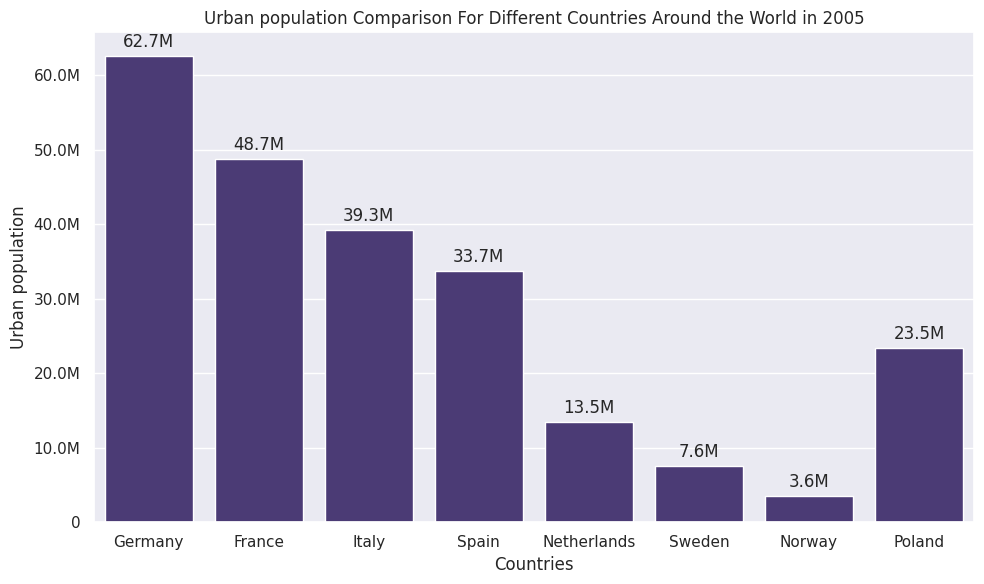

In [36]:
cols = ['Germany', 'France', 'Italy', 'Spain', 'Netherlands', 'Sweden', 'Norway', 'Poland', 'Year']
# Extract and reshape data for the years 2005 and 2015 from the 5th indicator (index 4: 'Urban population')
bar_2005 = extract_yearly_data_for_bar_chart(cols, 4, data_frames, '2005')
bar_2015 = extract_yearly_data_for_bar_chart(cols, 4, data_frames, '2015')
# Plot bar chart for 2005
plot_bar_with_annotations(
    bar_2005.iloc[:-1],                   # Remove the 'Year' row from data
    bar_2005.index[:-1],                  # Country names as x-axis
    '2005',                               # Column name for values
    'Urban population Comparison For Different Countries Around the World in 2005',  # Title
    'Countries',                          # x-axis label
    'Urban population'                    # y-axis label
)


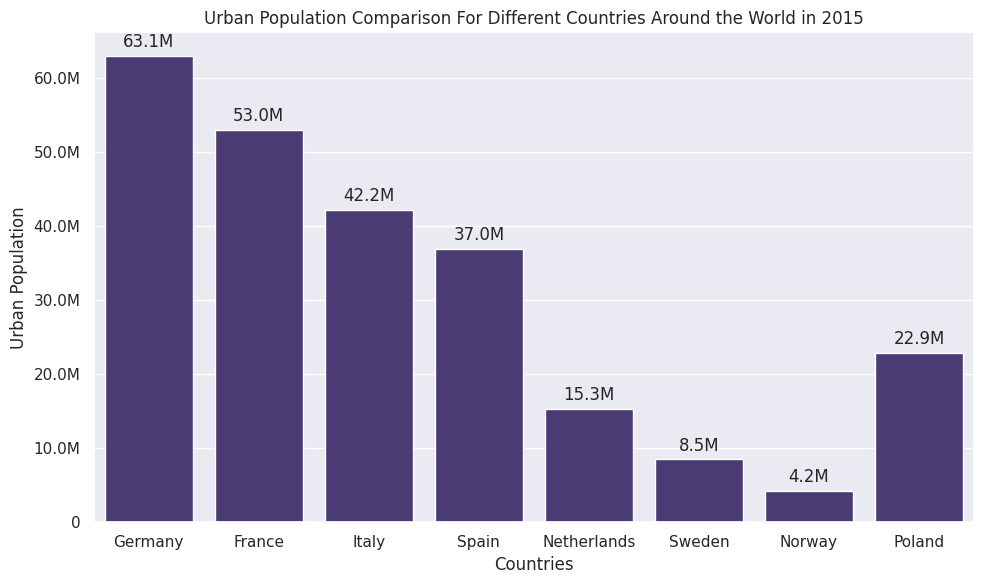

In [37]:
plot_bar_with_annotations(
    bar_2015.iloc[:-1],
    bar_2015.index[:-1],
    '2015',
    'Urban Population Comparison For Different Countries Around the World in 2015',
    'Countries',
    'Urban Population'
)


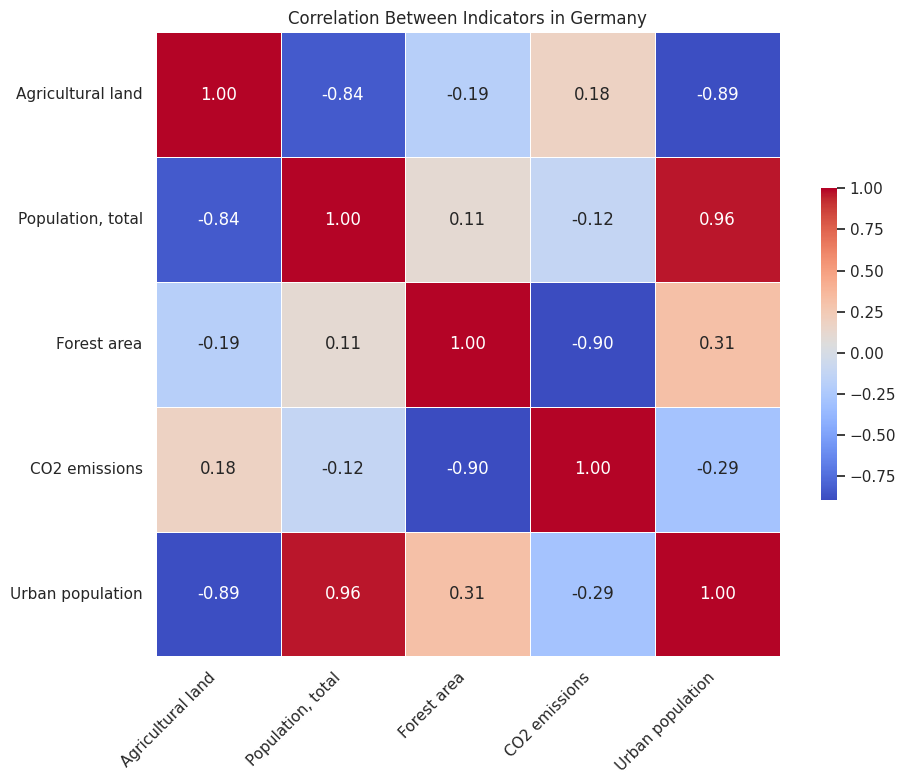

In [38]:
df = extract_country_data_for_heatmap(selected_indicators, data_frames, 'Germany')
plot_correlation_matrix(df, 'Correlation Between Indicators in Germany')

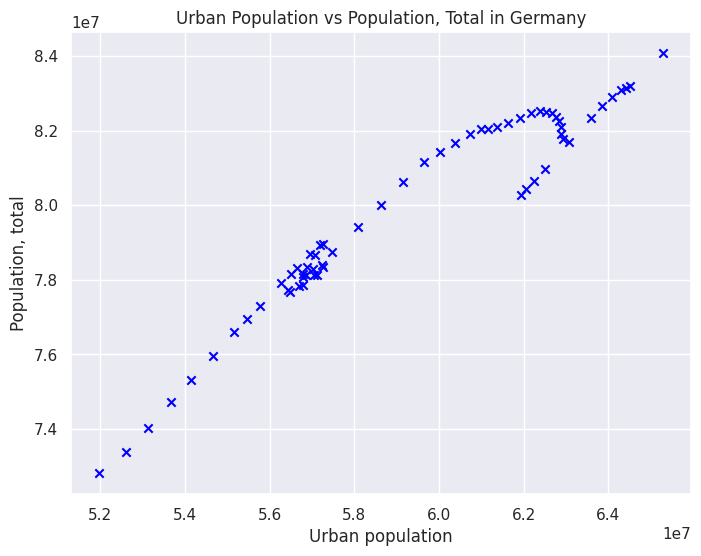

In [39]:
plot_scatter_with_optional_regression(
    df,
    'Urban population',
    'Population, total',
    with_regression=False,
    title='Urban Population vs Population, Total in Germany',
    xlabel='Urban population',
    ylabel='Population, total'
)


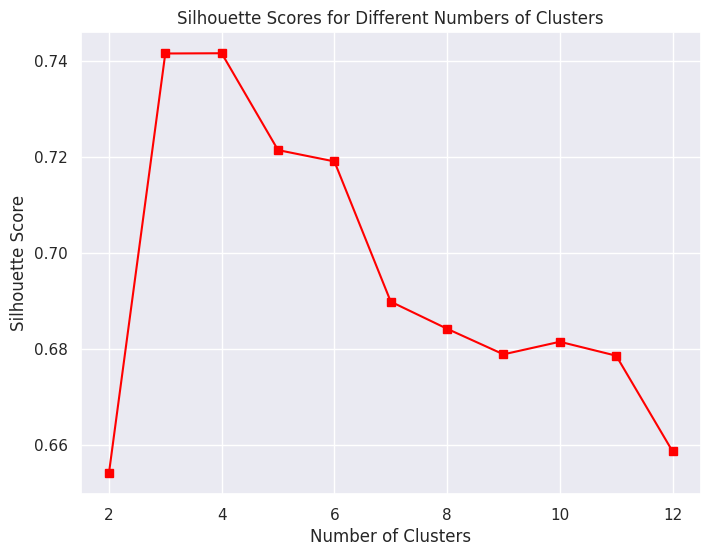

In [40]:
df_selected = df[['CO2 emissions', 'Forest area']]
train_df = df.sample(frac=0.9, random_state=42)  # Random state for reproducibility
test_df = df.drop(train_df.index)
# Scale the selected features
scaled_df, df_min, df_max = ct.scaler(df_selected)
# Create train-test split on scaled data (mirroring the unscaled split)
train_scaled_df = scaled_df.sample(frac=0.9, random_state=42)
test_scaled_df = scaled_df.drop(train_df.index)
# Evaluate and plot silhouette scores for cluster sizes 2 to 12
plot_silhouette_scores(scaled_df, max_clusters=12)


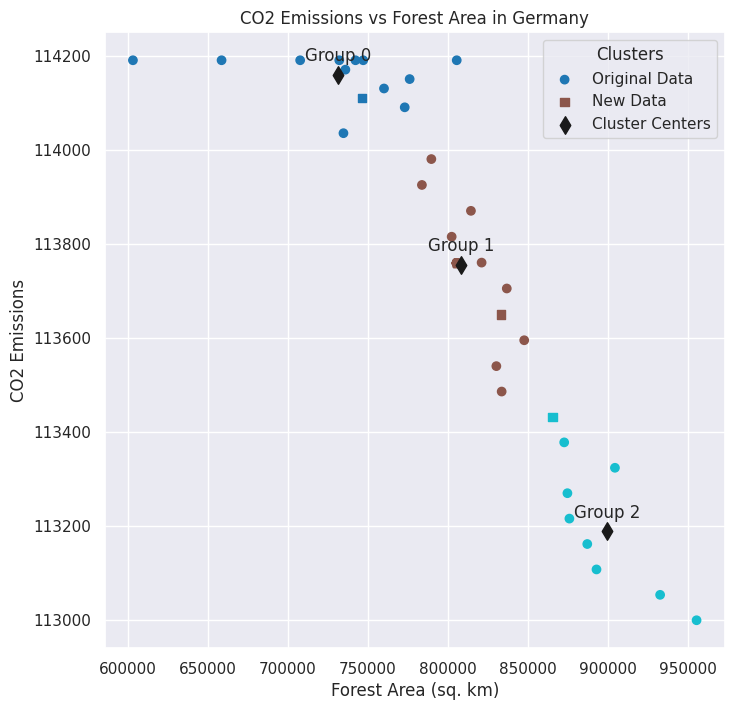

In [41]:
plot_kmeans_clusters_with_new_data(
    train_df,                     # Original training data for plotting
    'CO2 emissions',              # x-axis variable
    'Forest area',                # y-axis variable
    'Forest Area (sq. km)',       # x-axis label
    'CO2 Emissions',              # y-axis label
    'CO2 Emissions vs Forest Area in Germany',  # Plot title
    3,                            # Number of clusters
    train_scaled_df,             # Scaled data used for fitting the model
    df_min, df_max,              # Min-max arrays for rescaling cluster centers
    test_scaled_df,              # Scaled test data for prediction
    test_df                      # Original test data for plotting
)

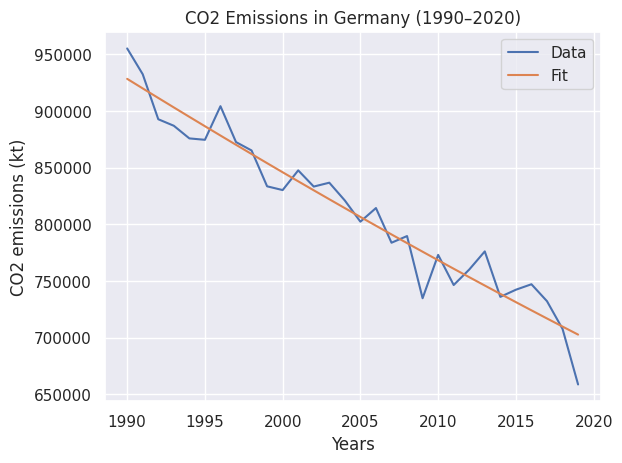

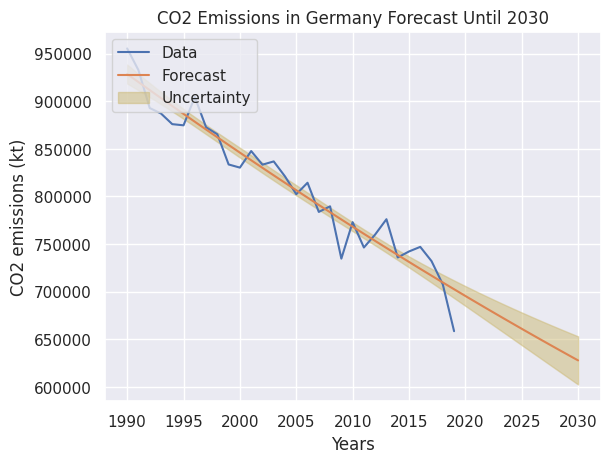

In [42]:
fit_and_forecast_logistic_model(
    get_country_data_by_year_range(data_frames[3], 'Germany', 1990, 2019),
    'Germany',
    'CO2 emissions (kt)',
    "CO2 Emissions in Germany (1990–2020)",
    "CO2 Emissions in Germany Forecast Until 2030",
    (10e6, -0.5, 1990.0)
)